In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import bartz
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
from stochtree import BARTModel
import time

## Concrete Compressive Strength Data

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete.data.features 
y = concrete.data.targets 

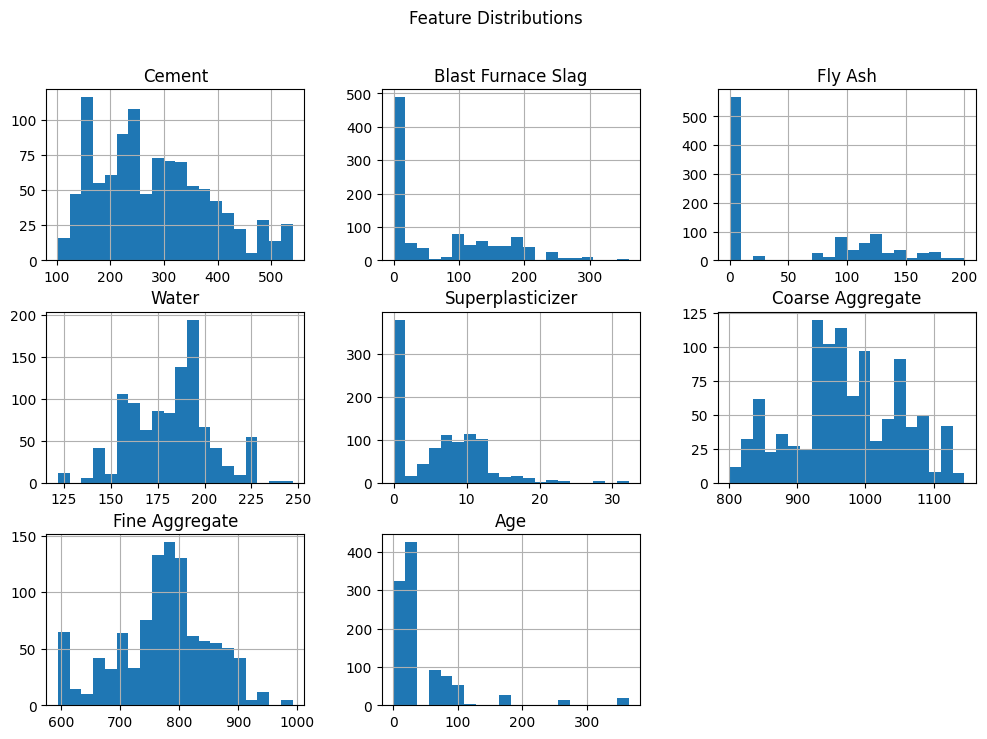

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

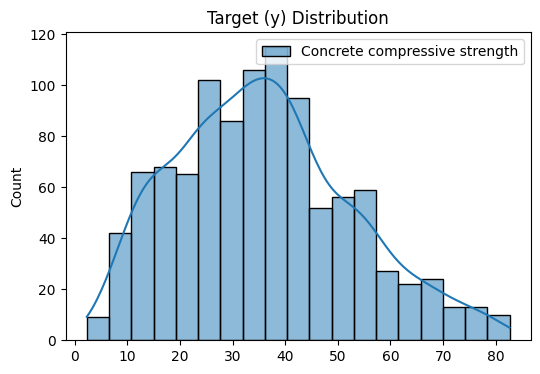

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

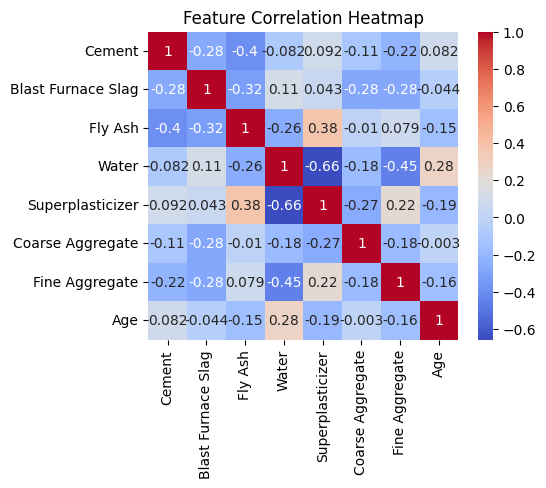

In [5]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [7]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.107088                 1.311005             1.282728   
1                  1.448094                 1.289173             1.617182   
2                  1.332252                 1.372176             1.549163   
3                  1.451472                 1.478060             1.260387   
4                  1.125919                 1.289592             1.246233   
mean               1.292965                 1.348001             1.391138   
std                0.168217                 0.080220             0.177422   

      DefaultBART_Rhat_RMSE  
0                  1.409610  
1                  1.136920  
2                  1.360690  
3                  1.690855  
4                  1.404680  
mean               1.400551  
std                0.197146  


In [8]:
rhat_df.to_csv("results/real4_Concrete_rhat.csv", index=False)

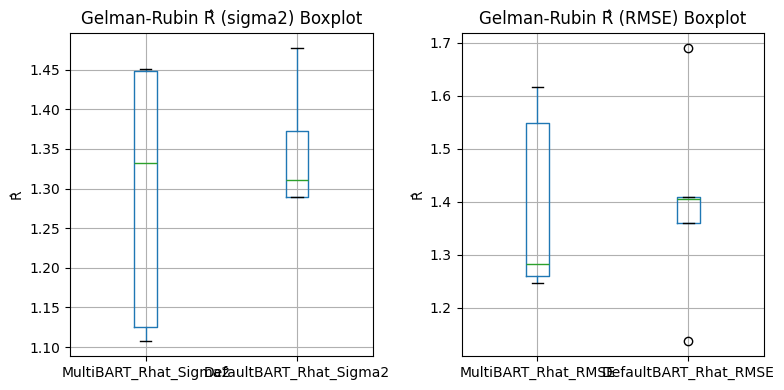

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

INFO:2025-10-28 18:24:27,833:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-28 18:24:28,309:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-10-28 18:24:28,431:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to op

test_mse:
      bart_mtmh       bart        btz         rf        xgb
0     17.313704  18.760777  21.362143  25.349766  22.455559
1     20.957949  22.658327  27.050820  28.011630  22.121190
2     21.218529  19.741603  23.918581  22.352354  20.070588
3     19.694848  21.468160  19.248111  24.326422  20.167277
4     18.747658  16.764766  17.999555  24.962981  20.543163
5     17.468613  21.198295  18.519385  26.308469  19.923279
6     21.544143  21.436583  19.867293  25.112951  20.328900
7     15.834764  18.130114  17.063325  21.417550  14.329891
8     19.970680  22.004878  19.631562  31.274851  32.522720
9     17.296558  19.948974  18.529000  25.420619  25.434845
mean  19.004745  20.211248  20.318977  25.453759  21.789741
std    1.967112   1.881590   3.047912   2.763007   4.683846



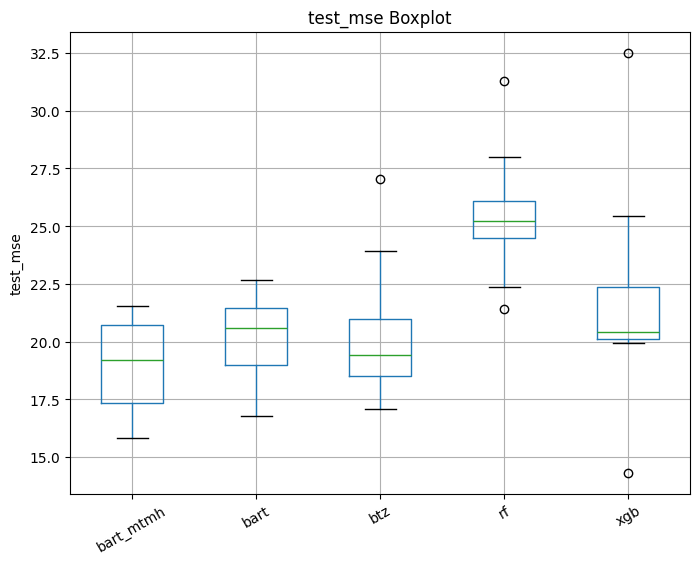

train_mse:
      bart_mtmh       bart       btz        rf       xgb
0      7.335287   7.844184  8.901967  4.499948  1.485153
1      7.244196   8.406521  7.525080  4.546035  1.495007
2      8.626999   8.030436  7.956732  4.562888  1.395256
3      6.106419   7.962312  8.305405  4.021529  1.089786
4      7.569372   9.110388  8.704103  4.354594  1.349169
5      8.216936   9.322538  8.465738  4.597305  1.337065
6      7.247510  10.195069  8.032752  4.630146  1.315198
7      5.947452   8.306093  9.538535  4.734191  1.460623
8      7.165925   8.965146  7.323742  3.413750  0.405178
9      5.438242   7.737197  7.768723  3.976311  0.462414
mean   7.089834   8.587988  8.252278  4.333670  1.179485
std    0.998767   0.790867  0.674079  0.410276  0.409934



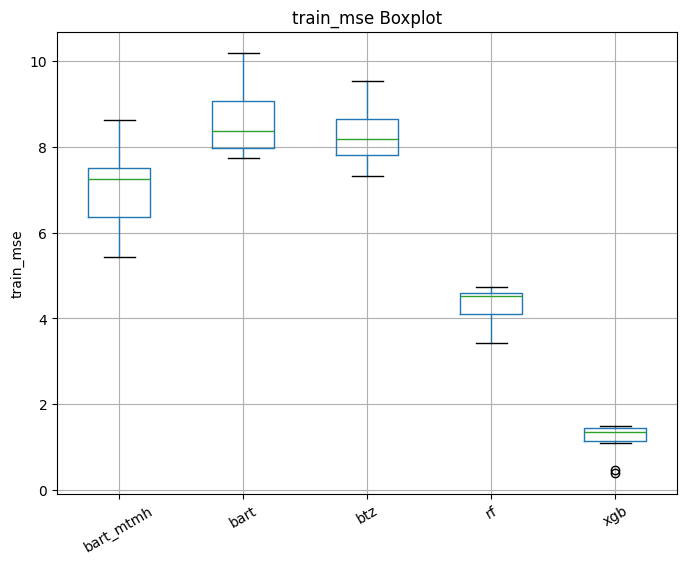

pi_length:
      bart_mtmh       bart        btz
0     13.968639  14.164128  16.861759
1     14.045053  14.548063  16.020235
2     13.814634  13.856349  16.695589
3     12.425672  14.381097  16.480904
4     14.571345  14.708651  16.578587
5     14.155633  15.151814  16.325237
6     13.371087  14.399518  16.623528
7     13.230979  14.653067  17.244490
8     13.262305  14.026215  16.612366
9     12.571223  13.664056  16.130213
mean  13.541657  14.355296  16.557291
std    0.694285   0.442135   0.353153



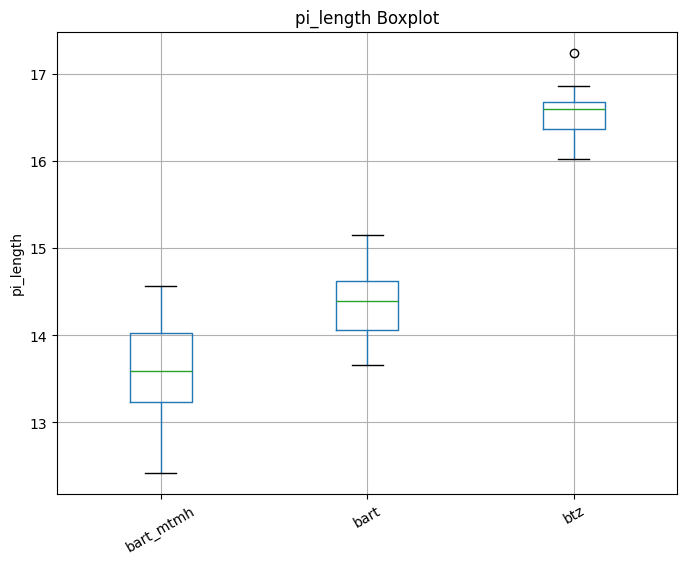

coverage:
      bart_mtmh      bart       btz
0      0.914729  0.910853  0.945736
1      0.910853  0.922481  0.899225
2      0.903101  0.930233  0.949612
3      0.887597  0.895349  0.937984
4      0.965116  0.937984  0.953488
5      0.922481  0.922481  0.945736
6      0.864341  0.856589  0.937984
7      0.910853  0.910853  0.957364
8      0.895349  0.883721  0.937984
9      0.899225  0.868217  0.930233
mean   0.907364  0.903876  0.939535
std    0.026062  0.027150  0.016363



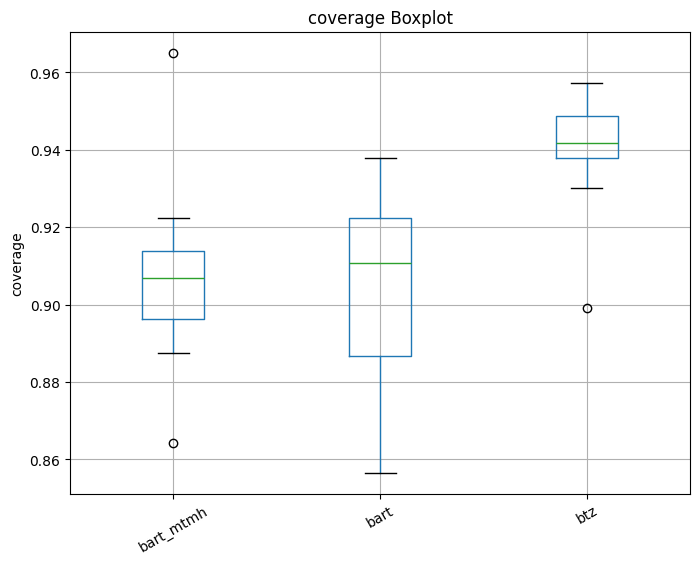

train_time:
       bart_mtmh       bart        btz        rf       xgb
0      90.071137  14.320623  23.369942  0.486705  0.133151
1      95.367737  14.727557  24.507376  0.490022  0.146129
2      95.171027  15.262326  24.584036  0.489727  0.139599
3      90.255217  14.246702  22.885772  0.494971  0.153167
4      89.545841  14.294636  23.313206  0.498784  0.148992
5      92.922472  14.424953  23.620188  0.493050  0.160160
6     109.236830  17.551934  24.140342  0.368936  0.116500
7      95.201735  20.156383  23.387104  0.544384  0.150766
8      97.042133  14.961331  23.762967  0.492732  0.135148
9      90.597118  14.648739  23.529853  0.516500  0.145813
mean   94.541125  15.459518  23.710079  0.487581  0.142943
std     5.823450   1.918165   0.546196  0.045200  0.012402



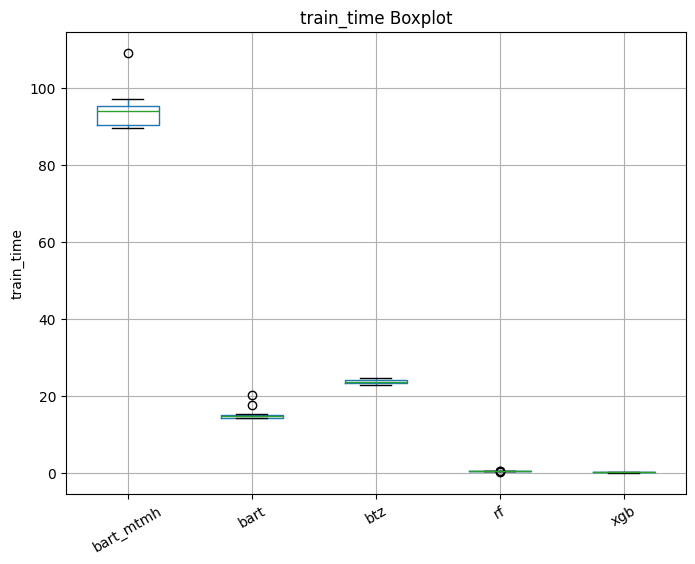

In [10]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [11]:
for k, v in mse_results.items():
    csv_name = f"results/real4_Concrete_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real4_Concrete_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real4_Concrete_tries.csv", index=False)

In [ ]:
print(df)